In [79]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [80]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)

    
    
    for file_path in json_files:
        print(f"Loading {file_path}")
        
        if "lnd1" in os.path.basename(file_path): # ln1 should be ignored as its the first participant and only half of the data is not corrupt
            continue
        
        # if in filename "all_all", skip
        if "all" in os.path.basename(file_path):
            continue

        if "loglinear" in os.path.basename(file_path).lower():
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            # if result['modelType'] in "logLinearMismatch_sharedPrior":
            #     continue
            
            if parts[2]=="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")



Loading model_fits/sx/sx_switchingFree_LapseFix_sharedPrior_fit.json
Loading model_fits/sx/sx_fusionOnlyLogNorm_LapseFix_sharedPrior_fit.json
Loading model_fits/sx/sx_lognorm_LapseFix_sharedPrior_fit.json
Loading model_fits/sx/sx_switchingFree_LapseFree_sharedPrior_fit.json
Loading model_fits/sx/sx_lognorm_LapseFree_sharedPrior_fit.json
Loading model_fits/sx/sx_logLinearMismatch_LapseFree_sharedPrior_fit.json
Loading model_fits/sx/sx_fusionOnlyLogNorm_LapseFree_sharedPrior_fit.json
Loading model_fits/sx/sx_selection_LapseFree_sharedPrior_fit.json
Loading model_fits/sx/sx_probabilityMatchingLogNorm_LapseFix_sharedPrior_fit.json
Loading model_fits/sx/sx_logLinearMismatch_LapseFix_sharedPrior_fit.json
Loading model_fits/sx/sx_selection_LapseFix_sharedPrior_fit.json
Loading model_fits/sx/sx_probabilityMatchingLogNorm_LapseFree_sharedPrior_fit.json
Loading model_fits/mt/mt_lognorm_LapseFree_sharedPrior_fit.json
Loading model_fits/mt/mt_fusionOnlyLogNorm_LapseFree_sharedPrior_fit.json
Loadin

In [81]:
def rename_model(best_models_df, old_name, new_name):
    """Rename a model name across all relevant DataFrames and variables."""
    # Rename in df_results
    best_models_df['modelType'] = best_models_df['modelType'].replace(old_name, new_name)
    
    # Rename in best_models_df
    best_models_df['best_model'] = best_models_df['best_model'].replace(old_name, new_name)
    
    # Rename in comparison_table_df
    comparison_table_df.columns = comparison_table_df.columns.map(
        lambda col: col if col[1] != old_name else (col[0], new_name)
    )
    
    # Rename in delta_aic_table
    delta_aic_table.columns = delta_aic_table.columns.str.replace(old_name, new_name)
    
    # Rename in ll_table
    ll_table.columns = ll_table.columns.str.replace(old_name, new_name)
    
    # Rename in simple_table
    simple_table.columns = simple_table.columns.str.replace(old_name, new_name)
    
    # Update participant_best_models
    global participant_best_models
    participant_best_models = [
        new_name if model == old_name else model for model in participant_best_models
    ]
    
    # Update ll_best_models
    global ll_best_models
    ll_best_models = [
        new_name if model == old_name else model for model in ll_best_models
    ]
    
    # Print confirmation
    print(f"Model name '{old_name}' has been renamed to '{new_name}'")


In [82]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]

            # delta AIC and BIC compared to the best model
            for _, row in participant_data.iterrows():
                if row['modelType'] != best_model['modelType']:
                    delta_AIC = row['AIC'] - best_model['AIC']
                    delta_BIC = row['BIC'] - best_model['BIC']
                    print(f"Participant {participant}, Model {row['modelType']} vs Best Model {best_model['modelType']}: ΔAIC={delta_AIC:.2f}, ΔBIC={delta_BIC:.2f}")
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood'],
                'delta_AIC': delta_AIC,
                'delta_BIC': delta_BIC
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")

Participant sx, Model fusionOnlyLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=19.54, ΔBIC=10.93
Participant sx, Model lognorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=20.85, ΔBIC=16.54
Participant sx, Model probabilityMatchingLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=18.16, ΔBIC=13.85
Participant sx, Model selection_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=6.25, ΔBIC=1.95
Participant mt, Model lognorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=2.50, ΔBIC=-1.39
Participant mt, Model selection_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=13.81, ΔBIC=9.93
Participant mt, Model probabilityMatchingLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=9.86, ΔBIC=5.98
Participant mt, Model fusionOnlyLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=8.25, ΔBIC=0.49
Participant mh, Model switchingFree_sharedPrior vs Best Model lognorm_sharedPrior: ΔAIC=3.23, ΔBIC

In [83]:
# Rename models in df_results BEFORE creating any tables
df_results['modelType'] = df_results['modelType'].replace({
    'probabilityMatchingLogNorm_sharedPrior': 'Probbility-Matching CI',
    'probabilityMatchingLogNorm': 'Prob-Matching CI',
    'probabilityMatching_sharedPrior': 'prob-Matching-Gauss',
    'switchingFree_sharedPrior': 'Free Switching',
    'switching_sharedPrior': 'Noise Dep. Switching',
    'switchingWithConflict_sharedPrior': 'Noise Dep. Switching + Conflict',
    'fusionOnly_sharedPrior': 'Fusion Only',
    'fusionOnlyLogNorm_sharedPrior': 'Forced Fusion',
    'lognorm_sharedPrior': 'Averaging CI',
    'gaussian_sharedPrior': 'Gaussian-Space CI',
    'lognorm_contextualPrior': 'Log-Space CI + Context',
    'logLinearMismatch_sharedPrior': 'Log-Linear Mismatch Avg CI',
    'selection_sharedPrior': 'Selection CI',
})

df_results["nParameters"] = [len(params) for params in df_results["fittedParams"]]
df_results["AIC_recalculated"] = 2 * df_results["nParameters"] - 2 * df_results["logLikelihood"]

print("Model names updated successfully!")
print(f"Current model types: {sorted(df_results['modelType'].unique())}")

Model names updated successfully!
Current model types: ['Averaging CI', 'Forced Fusion', 'Free Switching', 'Probbility-Matching CI', 'Selection CI']


In [84]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated
0,sx,Free Switching,"[0.03930565599016517, 0.07266671095401167, 0.3...",2140.065402,2165.903053,-1064.032701,548,6,2140.065402
1,sx,Forced Fusion,"[0.07341033347578571, 0.43358911162751324, 0.3...",2159.605469,2176.830570,-1075.802735,548,4,2159.605469
2,sx,Averaging CI,"[0.10815626760255545, 0.33398359366427166, 0.3...",2160.916234,2182.447610,-1075.458117,548,5,2160.916234
3,sx,Probbility-Matching CI,"[0.07101669503916491, 0.392610322044351, 0.337...",2158.224359,2179.755735,-1074.112179,548,5,2158.224359
4,sx,Selection CI,"[0.009376927780560429, 0.19851754706008873, 0....",2146.319521,2167.850897,-1068.159760,548,5,2146.319521
5,mt,Averaging CI,"[0.12117725636638352, 0.16079952865676306, 0.3...",2210.236653,2229.639318,-1100.118327,358,5,2210.236653
6,mt,Free Switching,"[0.09632305900603533, 0.15661175390839566, 0.1...",2207.741391,2231.024589,-1097.870695,358,6,2207.741391
7,mt,Selection CI,"[0.10751155459342554, 0.08057012089510973, 0.1...",2221.547538,2240.950203,-1105.773769,358,5,2221.547538
8,mt,Probbility-Matching CI,"[0.10365555303486049, 0.16832514567225787, 0.4...",2217.606267,2237.008932,-1103.803134,358,5,2217.606267
9,mt,Forced Fusion,"[0.10148883933371107, 0.17135857657798614, 0.4...",2215.992753,2231.514885,-1103.996377,358,4,2215.992753


In [85]:
(list(df_results[df_results['participantID']=='sx'][df_results['modelType']=='Averaging CI']["fittedParams"].values))

[[0.10815626760255545,
  0.33398359366427166,
  0.3100760087743587,
  0.9999999998137356,
  1.8364420235073844]]

In [86]:
# #df_results["delta_AIC"]

# for i, row in df_results.iterrows():
#     participant = row["participantID"]
#     model = row["modelType"]
#     participant_data = df_results[df_results["participantID"] == participant]
#     base_aic_participant = participant_data[participant_data["modelType"] == "Log-Space Causal"]["AIC"].values[0]
#     best_ll_participant = participant_data["logLikelihood"].max()
#     df_results.at[i, "delta_AIC"] = row["AIC"] - base_aic_participant
#     df_results.at[i, "delta_LL"] = best_ll_participant - row["logLikelihood"]
    

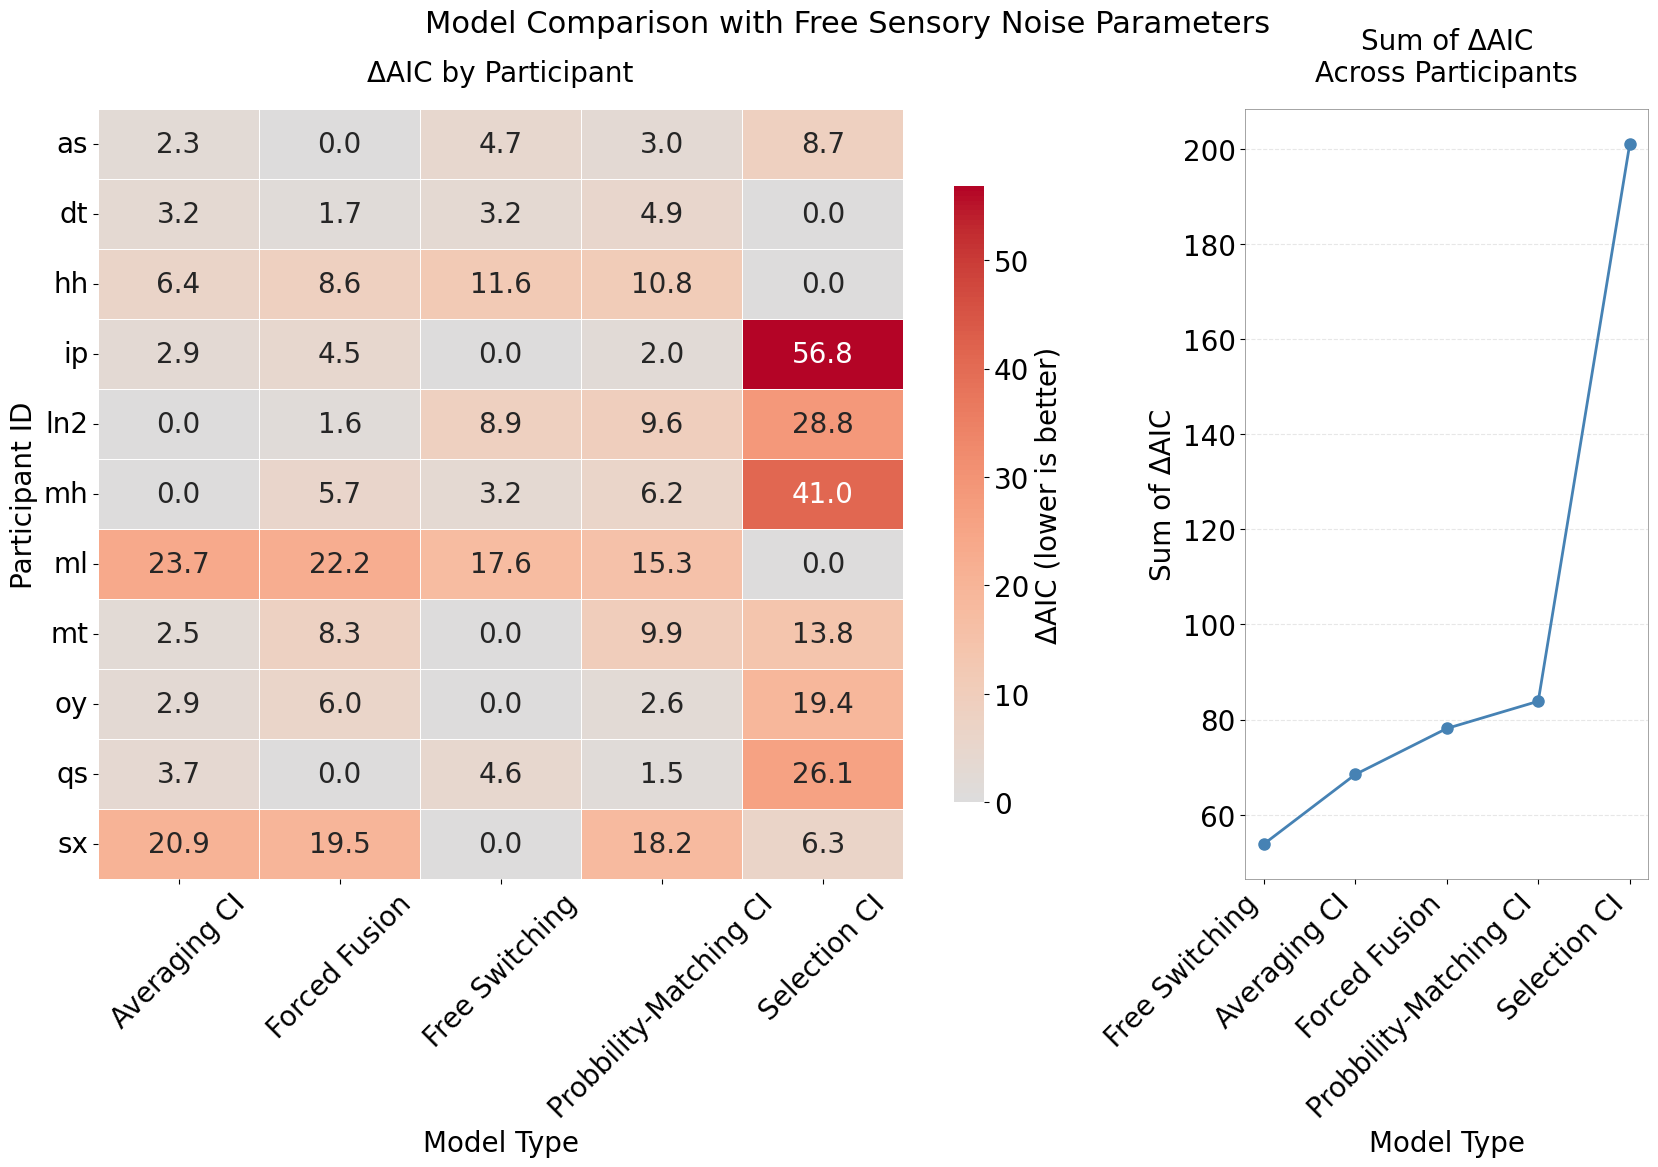


Best Model Counts (excluding benchmark models):
best_model
switchingFree_sharedPrior        4
selection_sharedPrior            3
lognorm_sharedPrior              2
fusionOnlyLogNorm_sharedPrior    2
Name: count, dtype: int64

Best Model Counts (excluding benchmark models):
best_model
switchingFree_sharedPrior        4
selection_sharedPrior            3
lognorm_sharedPrior              2
fusionOnlyLogNorm_sharedPrior    2
Name: count, dtype: int64


In [87]:
compTableTitle="Model Comparison with Free Sensory Noise Parameters"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sorted_model_comparison_table(
    df_results,
    compBase="AIC",
    exclude_from_counts=("Forced Fusion", "Fusion Only", "Fusion Only-Log", "fusionOnly", "fusionOnlyLogNorm"),
    include_in_heatmap=True,   # keep forced fusion visible in heatmap
    sort_by="sum_delta",       # "sum_delta" or "sum_compBase"
):
    """
    - Computes Δ(compBase) within participant (relative to best model for that participant).
    - Sorts participants by sum of Δ(compBase) (default).
    - Heatmap shows Δ(compBase) for all models (by default).
    - Best-model distribution EXCLUDES models in exclude_from_counts (benchmark models).
    """

    df = df_results.copy()

    # Ensure numeric
    df[compBase] = pd.to_numeric(df[compBase], errors="coerce")

    # Δ(compBase) per participant
    df["delta"] = df.groupby("participantID")[compBase].transform(lambda x: x - x.min())

    # Sorting participants
    if sort_by == "sum_delta":
        participant_sort = df.groupby("participantID")["delta"].sum().sort_values()
    elif sort_by == "sum_compBase":
        participant_sort = df.groupby("participantID")[compBase].sum().sort_values()
    else:
        raise ValueError("sort_by must be 'sum_delta' or 'sum_compBase'")
    #sorted_participants = participant_sort.index.tolist()
    # not sort by sum_delta, just sort by participantID
    sorted_participants = df["participantID"].unique().tolist()
    sorted_participants = sorted(df["participantID"].unique())

    # Heatmap dataframe
    if include_in_heatmap:
        df_heat = df
    else:
        df_heat = df[~df["modelType"].isin(exclude_from_counts)].copy()

    heat = df_heat.pivot(index="participantID", columns="modelType", values="delta").reindex(sorted_participants)

    # Best-model per participant (for counts), excluding benchmark models
    df_counts = df[~df["modelType"].isin(exclude_from_counts)].copy()

    best_models = []
    for pid in sorted_participants:
        d = df_counts[df_counts["participantID"] == pid]
        if len(d) == 0:
            best_models.append(None)  # edge case if everything excluded
            continue
        best_models.append(d.loc[d[compBase].idxmin(), "modelType"])

    best_models_clean = [m for m in best_models if m is not None]
    best_model_counts = pd.Series(best_models_clean).value_counts()

    # Calculate model sums for third panel
    model_sums = df.groupby("modelType")["delta"].sum().sort_values()

    # Plot with two panels

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"width_ratios": [2.5, 1]})

    fig.suptitle(compTableTitle, fontsize=22)


    heatmap = sns.heatmap(
        heat,
        annot=True,
        fmt=".1f",
        cmap="coolwarm",  # Use a perceptually uniform colormap
        center=0,         # Center the colormap at 0
        vmin=0,           # Set the minimum value for the color range
        vmax=heat.values.max(),  # Set the maximum value for the color range
        ax=ax1,
        cbar_kws={"label": f"Δ{compBase} (lower is better)", "shrink": 0.8},
        linewidths=0.5,
        linecolor="white",
        annot_kws={"fontsize": 20}
    )
    
    # Increase colorbar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.set_label(f"Δ{compBase} (lower is better)", fontsize=20)
    cbar.ax.tick_params(labelsize=20)
    
    ax1.set_title(f"Δ{compBase} by Participant", fontsize=20, pad=20)
    ax1.set_ylabel("Participant ID", fontsize=20)
    ax1.set_xlabel("Model Type", fontsize=20)
    ax1.tick_params(axis="x", rotation=45, labelsize=20)
    ax1.tick_params(axis="y", rotation=0, labelsize=20)
    ax1.set_facecolor('white')  # Set axes background to white
    fig.patch.set_facecolor('white')  # Set figure background to white

    # Remove gridlines from heatmap
    for _, spine in ax1.spines.items():
        spine.set_visible(False)

    # Sum of ΔAIC by model panel
    ax2.plot(range(len(model_sums)), model_sums.values, marker="o", linestyle="-", linewidth=2, markersize=8, color='steelblue')
    ax2.set_xticks(range(len(model_sums)))
    ax2.set_xticklabels(model_sums.index, rotation=45, ha='right', fontsize=20)
    ax2.set_ylabel(f"Sum of Δ{compBase}", fontsize=20)
    ax2.set_xlabel("Model Type", fontsize=20)
    ax2.set_title(f"Sum of Δ{compBase}\nAcross Participants", fontsize=20, pad=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_facecolor('white')
    for _, spine in ax2.spines.items():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)


    plt.savefig('model comp w free sensory noise.png', dpi=600)
    #plt.tight_layout()
    plt.show()
    return heat, best_models, participant_sort

heat, best_models, participant_sort = plot_sorted_model_comparison_table(
    df_results,
    compBase="AIC",
    exclude_from_counts=(),   # Include all models in counts
    include_in_heatmap=True,
    sort_by="sum_delta"
)



print("\nBest Model Counts (excluding benchmark models):")
print(model_counts)
#save as png
#plt.savefig("model comp w free sensory noise.png", dpi=300, bbox_inches='tight')
print("\nBest Model Counts (excluding benchmark models):")
print(model_counts)

Participants sorted by sum of delta_AIC across all models (lowest to highest):
Delta_AIC sums: {'dt': 13.01343837211789, 'as': 18.615908120505082, 'oy': 30.909345991954524, 'mt': 34.41764929615056, 'qs': 35.94203011327045, 'hh': 37.39890914478269, 'ln2': 48.852210358017146, 'mh': 56.15148320203389, 'sx': 64.80397541873845, 'ip': 66.18553227707798, 'ml': 78.85162384873911}


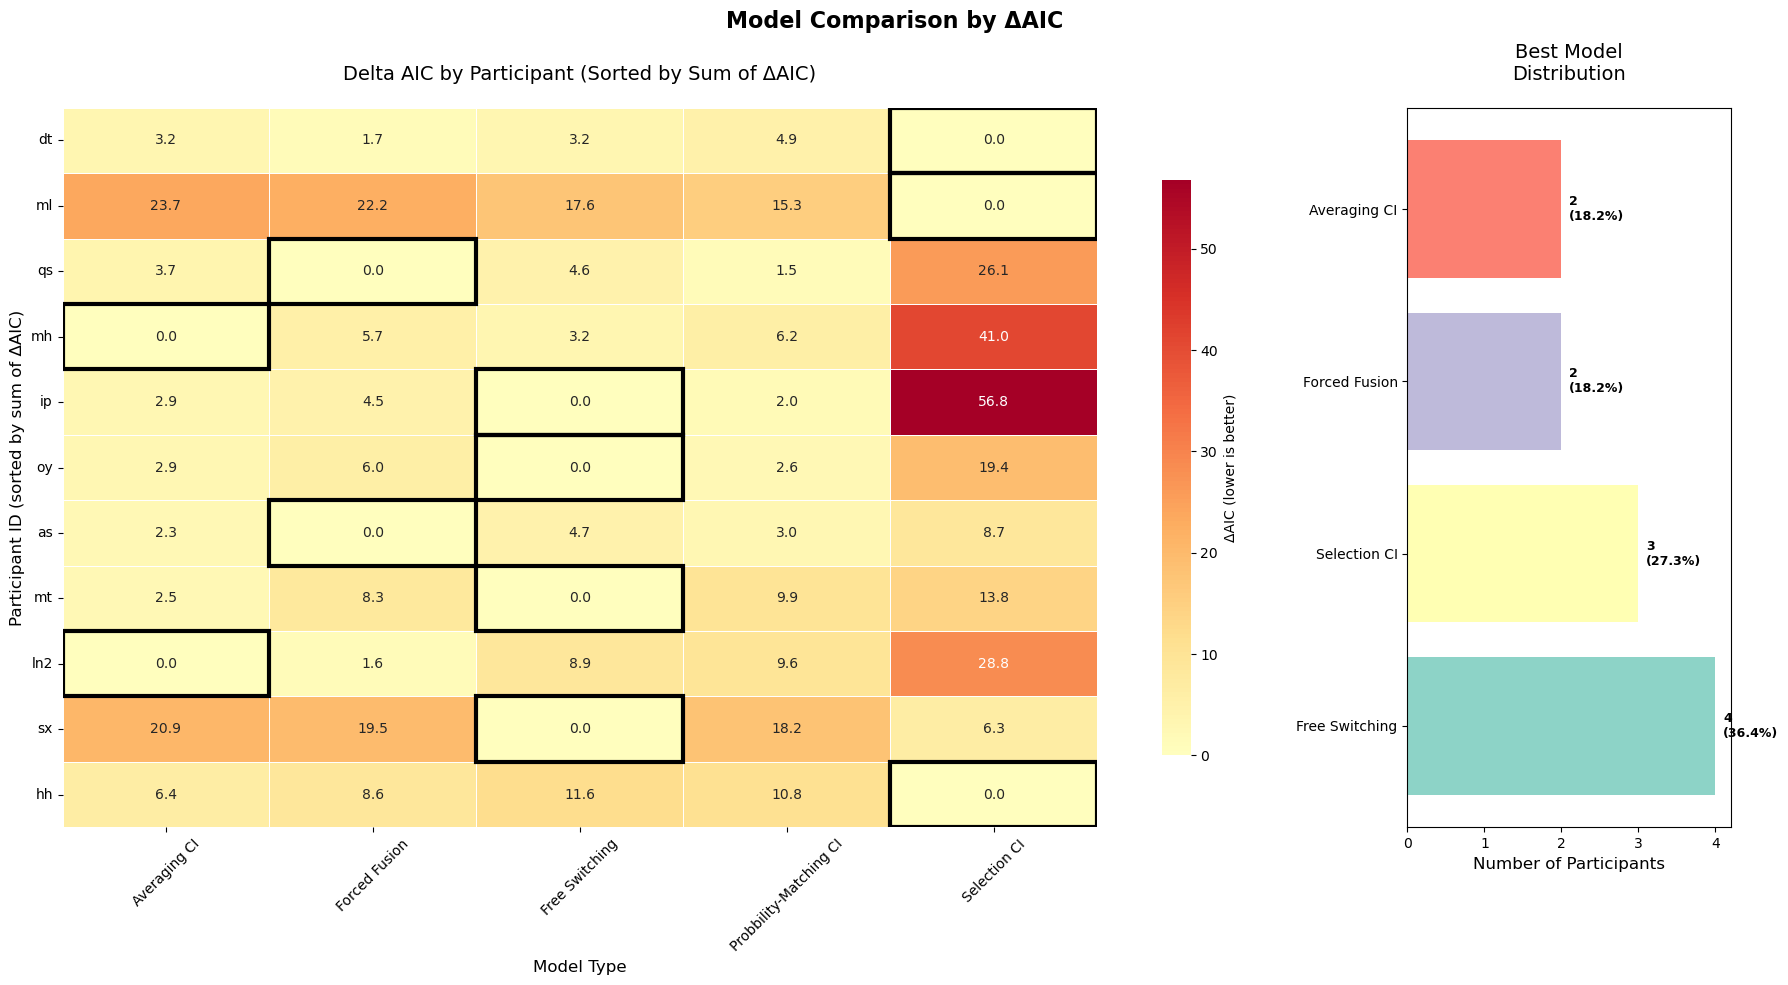

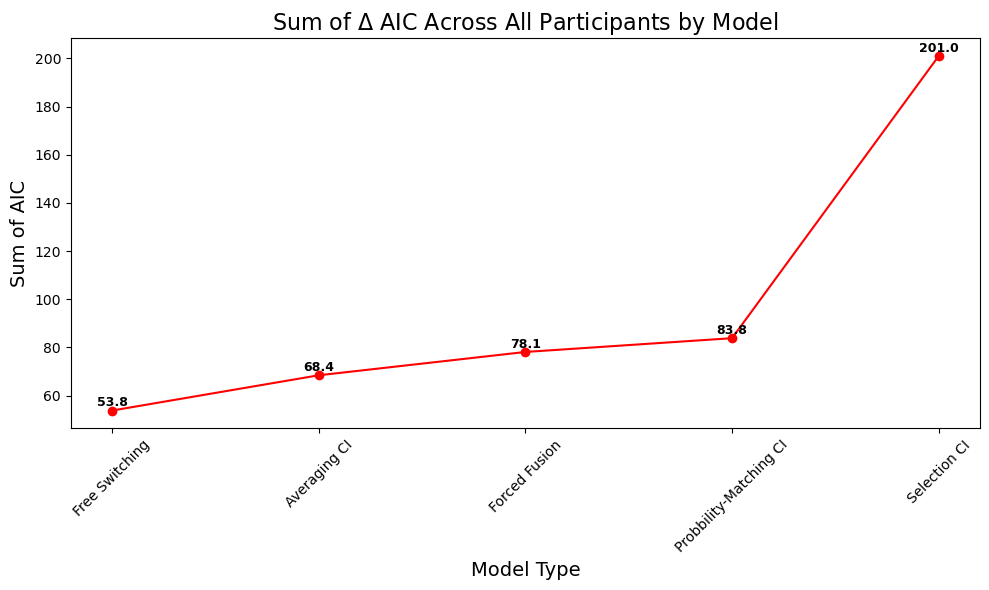

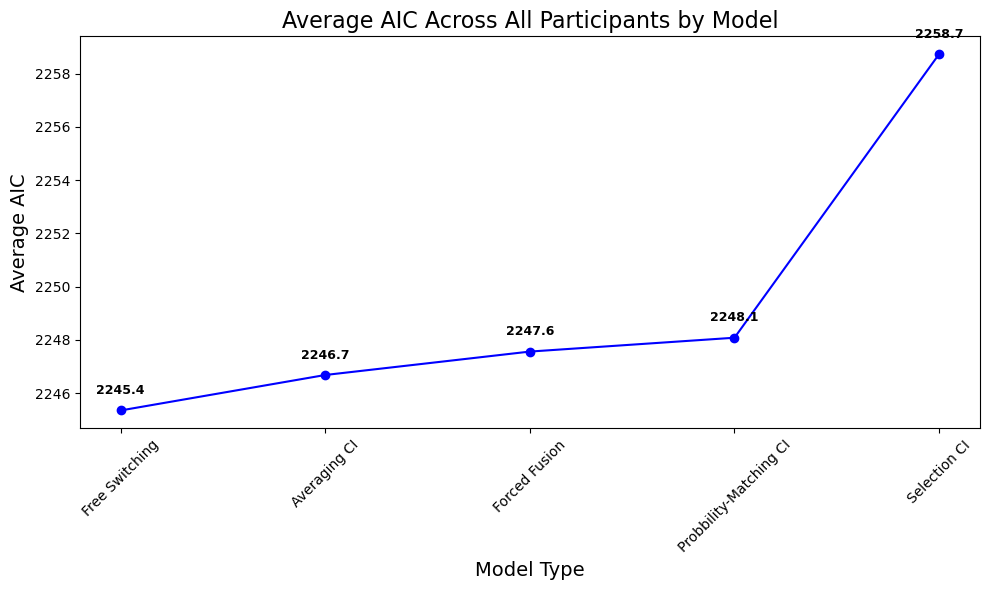

1    dt           12745.0    Selection CI       2546.4     Poor fit       
2    ml           12534.5    Selection CI       2491.1     Poor fit       
3    qs           12528.7    Forced Fusion      2498.5     Poor fit       
4    mh           12250.8    Averaging CI       2438.9     Poor fit       
5    ip           12073.3    Free Switching     2401.4     Poor fit       
6    oy           11628.8    Free Switching     2319.6     Poor fit       
7    as           11250.8    Forced Fusion      2246.4     Poor fit       
8    mt           11073.1    Free Switching     2207.7     Poor fit       
9    ln2          10885.7    Averaging CI       2167.4     Poor fit       
10   sx           10765.1    Free Switching     2140.1     Poor fit       
11   hh           5974.8     Selection CI       1187.5     Poor fit       


In [88]:
# Calculate delta_AIC for each model relative to the best model per participant
df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())

# Sort participants by sum of delta_AIC across all models (lower sum = better overall performance)
participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
sorted_participants = participant_delta_sums.index.tolist()
print("Participants sorted by sum of delta_AIC across all models (lowest to highest):")
print(f"Delta_AIC sums: {participant_delta_sums.to_dict()}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced table-style visualization
def plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=1, sumCompBase=0):
    
    if notFusion:
        removeModels= ["Fusion Only", "Fusion Only-Log"]
        df_results = df_results[~df_results['modelType'].isin(removeModels)]
    """Create a comprehensive table plot with participants sorted by sum of delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')[compBase].transform(lambda x: x - x.min())
    
    # Sort participants by sum of delta_AIC across all models
    participant_delta_sums = df_results.groupby('participantID')['logLikelihood'].sum().sort_values()
    sorted_participants = participant_delta_sums.index.tolist()
    
    # Create the pivot table with sorted participants
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    df_delta_aic = df_delta_aic.reindex(sorted_participants)
    
    # Find best model for each participant
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle(f'Model Comparison by Δ{compBase}', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta_AIC values
    sns.heatmap(df_delta_aic, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': f'Δ{compBase} (lower is better)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title(f'Delta {compBase} by Participant (Sorted by Sum of Δ{compBase})', fontsize=14, pad=20)
    ax1.set_ylabel(f'Participant ID (sorted by sum of Δ{compBase})', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_aic.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a star or border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # we want to plot a line chart of sum of AIC per model
    model_sums = df_results.groupby('modelType')["delta_AIC"].sum().sort_values()
    plt.figure(figsize=(10, 6))
    plt.plot(model_sums.index, model_sums.values, marker='o', linestyle='-', color='r')
    plt.title(f'Sum of $\Delta$ AIC Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel(f'Sum of {compBase}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    # Add value labels on points
    for i, value in enumerate(model_sums.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Another plot to show average AIC per model as a line plot
    model_means = df_results.groupby('modelType')[compBase].mean().sort_values()
    plt.figure(figsize=(10, 6))
    plt.plot(model_means.index, model_means.values, marker='o', linestyle='-', color='b')
    # Add value labels on points
    for i, value in enumerate(model_means.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.title(f'Average {compBase} Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel(f'Average {compBase}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data[compBase].sum()
        min_delta_aic = participant_data[compBase].min()
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        
        if sum_delta_aic <= 5:
            performance = "Excellent fit"
        elif sum_delta_aic <= 15:
            performance = "Good fit"
        elif sum_delta_aic <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_aic:<10.1f} {best_model:<18} {min_delta_aic:<10.1f} {performance:<15}")
    
    return df_delta_aic, best_models, participant_delta_sums

# Create the enhanced visualization
delta_aic_table, participant_best_models, delta_sums = plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=0,sumCompBase=1)

In [89]:
# Simple Model Comparison Table with Log Likelihoods
def create_simple_comparison_table(df_results):
    """Create a simple comparison table focused on log likelihoods"""
    
    # Pivot to show log likelihoods for each participant-model combination
    log_likelihood_table = df_results.pivot(
        index='participantID', 
        columns='modelType', 
        values='logLikelihood'
    )
    
    # Sort participants by ID for consistent ordering
    log_likelihood_table = log_likelihood_table.sort_index()
    
    return log_likelihood_table

# Create the simple comparison table
simple_table = create_simple_comparison_table(df_results)

print("Model Comparison Table - Log Likelihoods")
print("=" * 80)
print("Higher values indicate better fit")
print("=" * 80)
print()

# Display with better formatting
pd.set_option('display.float_format', '{:.2f}'.format)
display(simple_table)

# Reset display options
pd.reset_option('display.float_format')

Model Comparison Table - Log Likelihoods
Higher values indicate better fit



modelType,Averaging CI,Forced Fusion,Free Switching,Probbility-Matching CI,Selection CI
participantID,,,,,
as,-1119.37,-1119.22,-1119.54,-1119.70,-1122.56
dt,-1269.77,-1270.06,-1268.82,-1270.64,-1268.20
hh,-591.95,-594.02,-593.54,-594.15,-588.74
ip,-1197.16,-1198.96,-1194.72,-1196.71,-1224.13
ln2,-1078.69,-1080.51,-1082.11,-1083.47,-1093.09
mh,-1214.46,-1218.31,-1215.08,-1217.56,-1234.99
ml,-1252.40,-1252.69,-1248.35,-1248.24,-1240.56
mt,-1100.12,-1104.00,-1097.87,-1103.80,-1105.77
oy,-1156.25,-1158.78,-1153.79,-1156.07,-1164.51


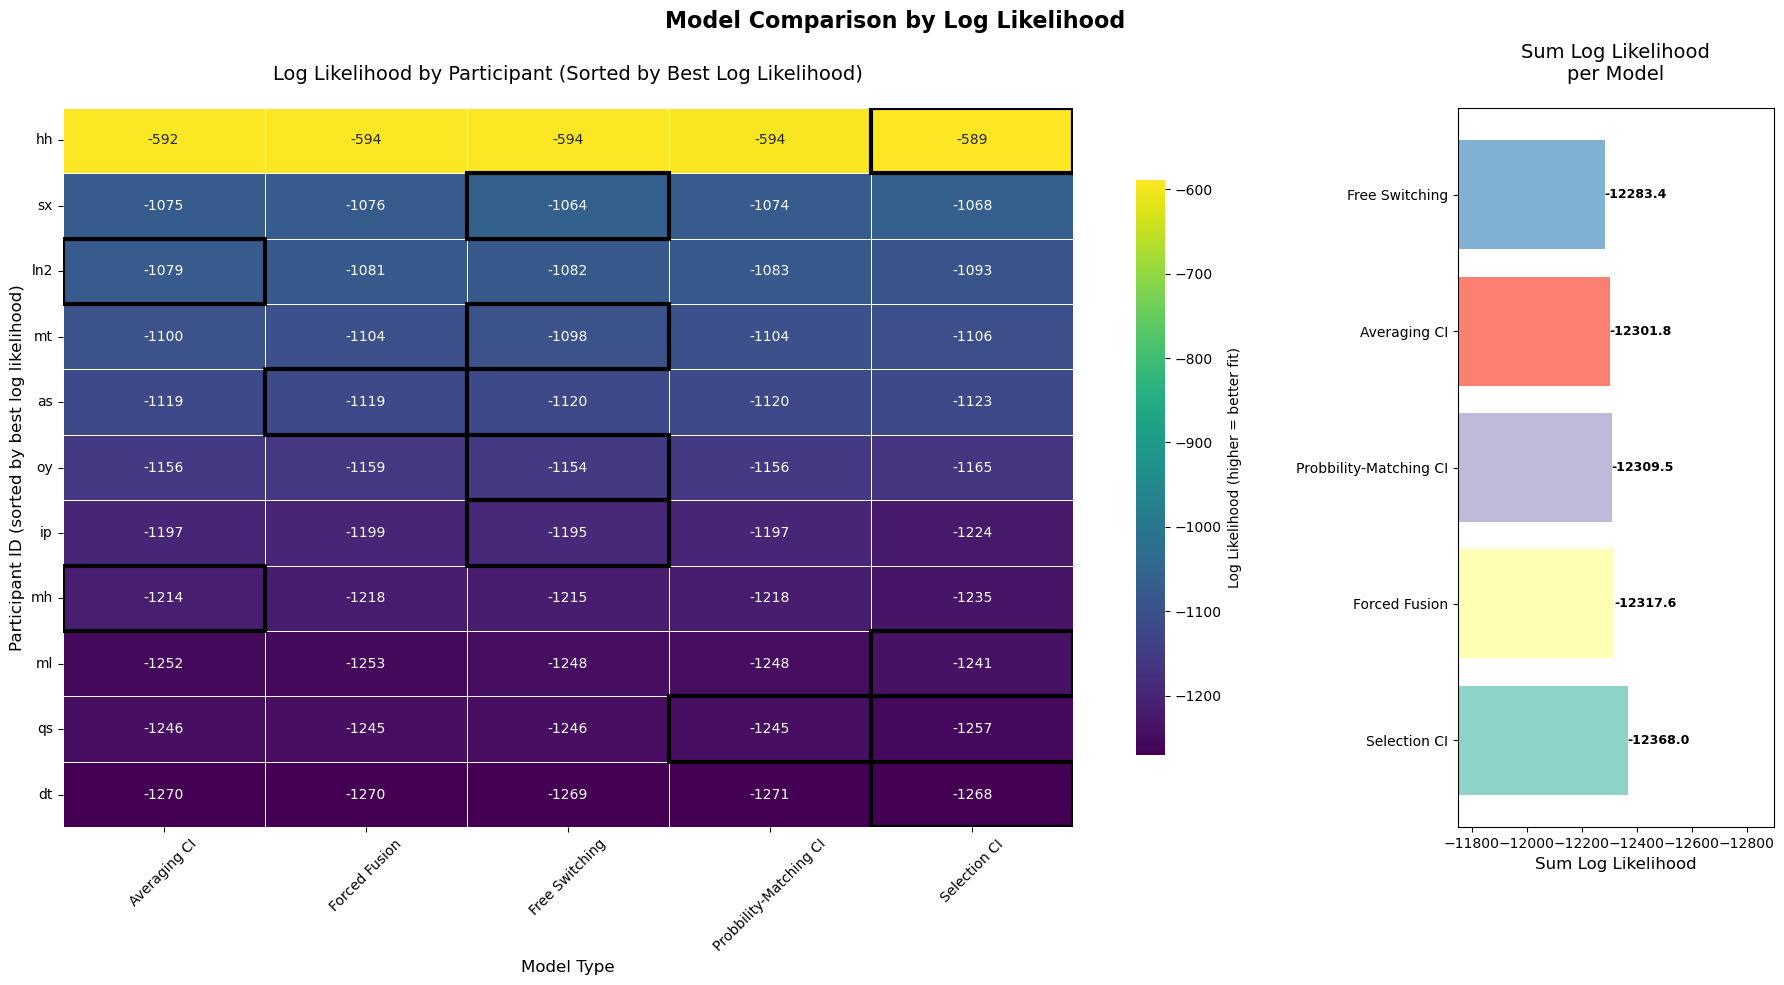


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           -589       Selection CI       37.4       Excellent fit  
2    sx           -1064      Free Switching     64.8       Moderate fit   
3    ln2          -1079      Averaging CI       48.9       Moderate fit   
4    mt           -1098      Free Switching     34.4       Moderate fit   
5    as           -1119      Forced Fusion      18.6       Moderate fit   
6    oy           -1154      Free Switching     30.9       Moderate fit   
7    ip           -1195      Free Switching     66.2       Moderate fit   
8    mh           -1214      Averaging CI       56.2       Poor fit       
9    ml           -1241      Selection CI       78.9       Poor fit       
10   qs           -1245      Probbility-Matching CI 35.9       Poor fit       
11   dt           -12

In [90]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns


def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Sum Log Likelihood per model - sum across rows (participants) for each model column
    sum_ll = df_log_likelihood.sum(axis=0).sort_values()  # sum across participants for each model
    colors = plt.cm.Set3(range(len(sum_ll)))
    
    bars = ax2.barh(range(len(sum_ll)), sum_ll.values, color=colors)
    ax2.set_yticks(range(len(sum_ll)))
    ax2.set_yticklabels(sum_ll.index, fontsize=10)
    ax2.set_xlabel('Sum Log Likelihood', fontsize=12)
    ax2.set_title('Sum Log Likelihood\nper Model', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sum_ll.values)):
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Set limits for the heatmap axes
    ax2.set_xlim(min(sum_ll.values)*0.95, max(sum_ll.values)*1.05)

    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models
# ...existing code...

    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

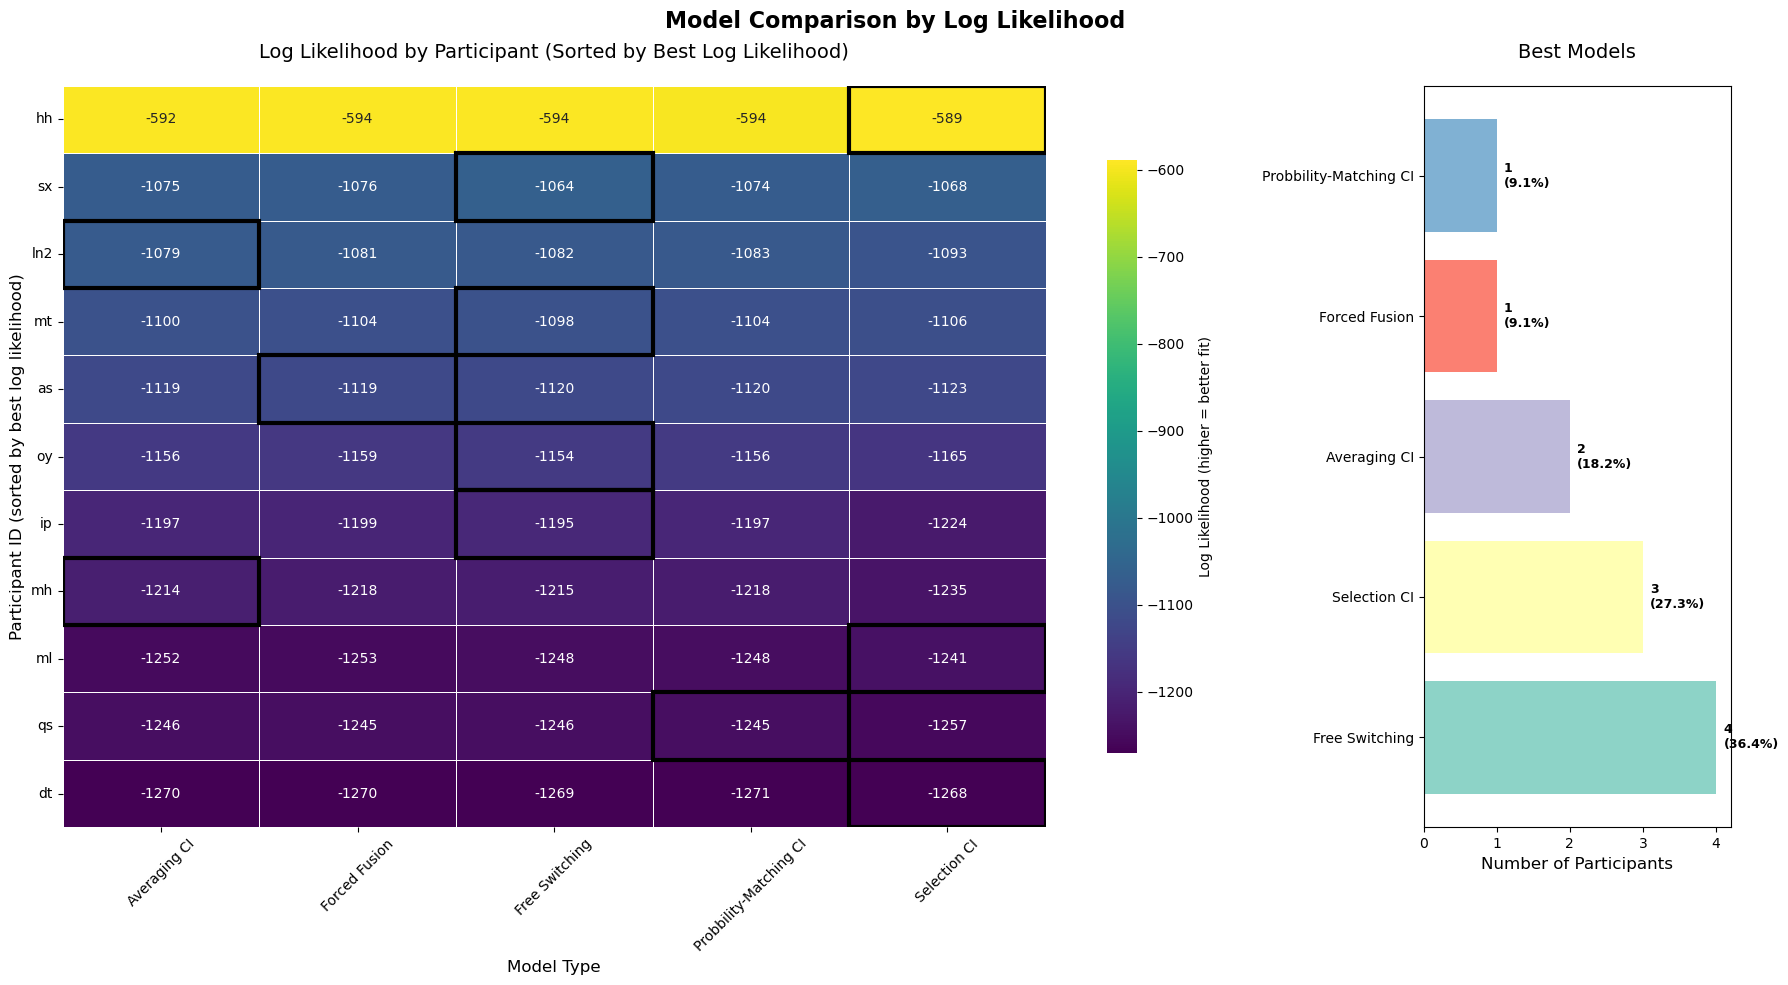


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           -589       Selection CI       37.4       Excellent fit  
2    sx           -1064      Free Switching     64.8       Moderate fit   
3    ln2          -1079      Averaging CI       48.9       Moderate fit   
4    mt           -1098      Free Switching     34.4       Moderate fit   
5    as           -1119      Forced Fusion      18.6       Moderate fit   
6    oy           -1154      Free Switching     30.9       Moderate fit   
7    ip           -1195      Free Switching     66.2       Moderate fit   
8    mh           -1214      Averaging CI       56.2       Poor fit       
9    ml           -1241      Selection CI       78.9       Poor fit       
10   qs           -1245      Probbility-Matching CI 35.9       Poor fit       
11   dt           -12

In [91]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Models', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

In [92]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated,delta_AIC
0,sx,Free Switching,"[0.03930565599016517, 0.07266671095401167, 0.3...",2140.065402,2165.903053,-1064.032701,548,6,2140.065402,0.000000
1,sx,Forced Fusion,"[0.07341033347578571, 0.43358911162751324, 0.3...",2159.605469,2176.830570,-1075.802735,548,4,2159.605469,19.540068
2,sx,Averaging CI,"[0.10815626760255545, 0.33398359366427166, 0.3...",2160.916234,2182.447610,-1075.458117,548,5,2160.916234,20.850832
3,sx,Probbility-Matching CI,"[0.07101669503916491, 0.392610322044351, 0.337...",2158.224359,2179.755735,-1074.112179,548,5,2158.224359,18.158957
4,sx,Selection CI,"[0.009376927780560429, 0.19851754706008873, 0....",2146.319521,2167.850897,-1068.159760,548,5,2146.319521,6.254119
5,mt,Averaging CI,"[0.12117725636638352, 0.16079952865676306, 0.3...",2210.236653,2229.639318,-1100.118327,358,5,2210.236653,2.495263
6,mt,Free Switching,"[0.09632305900603533, 0.15661175390839566, 0.1...",2207.741391,2231.024589,-1097.870695,358,6,2207.741391,0.000000
7,mt,Selection CI,"[0.10751155459342554, 0.08057012089510973, 0.1...",2221.547538,2240.950203,-1105.773769,358,5,2221.547538,13.806148
8,mt,Probbility-Matching CI,"[0.10365555303486049, 0.16832514567225787, 0.4...",2217.606267,2237.008932,-1103.803134,358,5,2217.606267,9.864877
9,mt,Forced Fusion,"[0.10148883933371107, 0.17135857657798614, 0.4...",2215.992753,2231.514885,-1103.996377,358,4,2215.992753,8.251362


In [93]:
import numpy as np
import matplotlib.pyplot as plt
def plot_parameter_fits(df_results,model_name='Log-Space Causal'):
    # example fittedParams for Log-Space Causal model
    # fittedParams: [lambda_1, sigma_a, sigma_v, sigma_a2,lambda_2, lambda_3]
    participantIDs= sorted(df_results['participantID'].unique())
    modelTypes= sorted(df_results['modelType'].unique())
    paramFits= {}
    for pid in participantIDs:
        participant_data = df_results[df_results['participantID'] == pid]
        pid_lognorm_fit = participant_data[participant_data['modelType'] == model_name]
        lambda_1_Fit = pid_lognorm_fit['fittedParams'].values[0][0]
        sigma_a_Fit = pid_lognorm_fit['fittedParams'].values[0][1]
        sigma_v_Fit = pid_lognorm_fit['fittedParams'].values[0][2]
        p_c= pid_lognorm_fit['fittedParams'].values[0][3]
        sigma_a2_Fit = pid_lognorm_fit['fittedParams'].values[0][4]
        lambda_2_Fit = pid_lognorm_fit['fittedParams'].values[0][5]
        lambda_3_Fit = pid_lognorm_fit['fittedParams'].values[0][6]    
        print(f"Participant {pid}: lambda_1={lambda_1_Fit}, sigma_a={sigma_a_Fit}, sigma_v={sigma_v_Fit}, p_c={p_c},sigma_a2={sigma_a2_Fit}, lambda_2={lambda_2_Fit}, lambda_3={lambda_3_Fit}")
        paramFits[pid]= {
            'lambda_1': lambda_1_Fit,
            'sigma_a': sigma_a_Fit,
            'sigma_v': sigma_v_Fit,
            'p_c': p_c,
            'sigma_a2': sigma_a2_Fit,
            'lambda_2': lambda_2_Fit,
            'lambda_3': lambda_3_Fit
        }

    




    # plot the parameter fits scatter plot with jittered x-axis values for each parameter
    plt.figure(figsize=(10, 6))
    parameters = ['lambda_1', 'sigma_a', 'sigma_v', 'p_c', 'sigma_a2', 'lambda_2', 'lambda_3']
    x_positions = np.arange(len(parameters))
    for pid in participantIDs:
        if pid=='all':
            # color='red'
            # fits = paramFits[pid]
            # y_values = [fits[param] for param in parameters]
            # plt.scatter(x_positions, y_values, label=pid, color=color, s=100, edgecolor='red')
            continue
        fits = paramFits[pid]
        y_values = [fits[param] for param in parameters]
        # Add jitter to x positions
        jitter = np.random.uniform(-0.1, 0.1, size=len(parameters))
        plt.scatter(x_positions + jitter, y_values, label=pid)

    # Add mean markers for each parameter
    for i, param in enumerate(parameters):
        mean_value = np.mean([paramFits[pid][param] for pid in participantIDs])
        plt.scatter(i, mean_value, color='black', marker='D', s=50, alpha=0.8,label='Mean' if i == 0 else "")

    plt.xticks(x_positions, parameters)
    plt.ylabel('Fitted Parameter Value')
    plt.title('Fitted Parameters for Log-Space Causal Model Across Participants')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_parameter_fits(df_results,model_name='Log-Space Causal')

IndexError: index 0 is out of bounds for axis 0 with size 0

Found 5 models: ['Averaging CI', 'Forced Fusion', 'Free Switching', 'Probbility-Matching CI', 'Selection CI']
Found 11 participants: ['as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']

Model 'Averaging CI': 11 entries, 5 parameters
  Plotting 11 participants


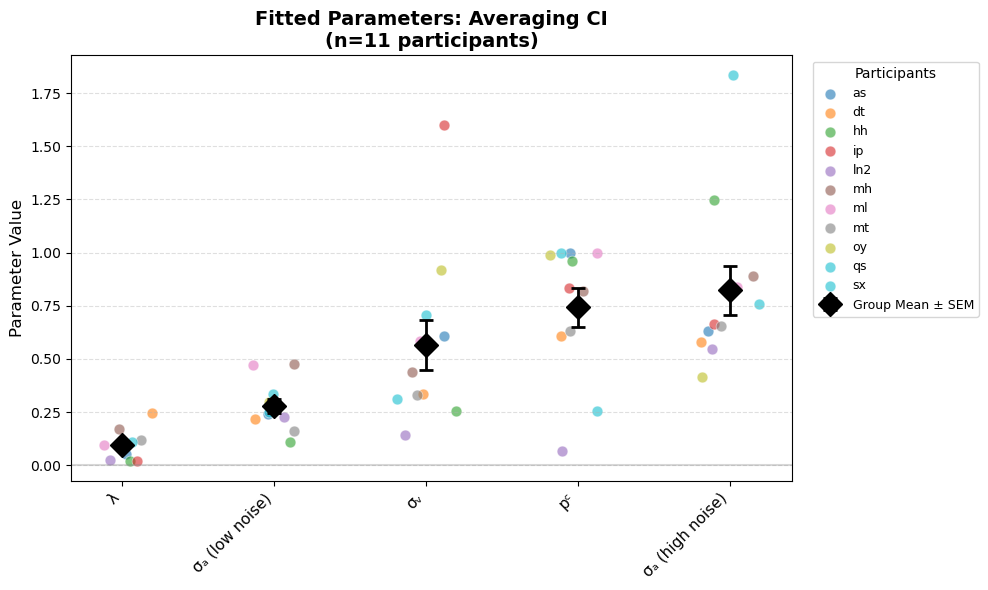


Model: Averaging CI
Parameter                       Mean         SD        SEM        Min        Max
---------------------------------------------------------------------------
λ                             0.0945     0.0660     0.0199     0.0189     0.2469
σₐ (low noise)                0.2803     0.1088     0.0328     0.1116     0.4746
σᵥ                            0.5656     0.3911     0.1179     0.1429     1.6001
pᶜ                            0.7424     0.3085     0.0930     0.0669     1.0000
σₐ (high noise)               0.8238     0.3822     0.1152     0.4132     1.8364

Model 'Forced Fusion': 11 entries, 4 parameters
  Plotting 11 participants


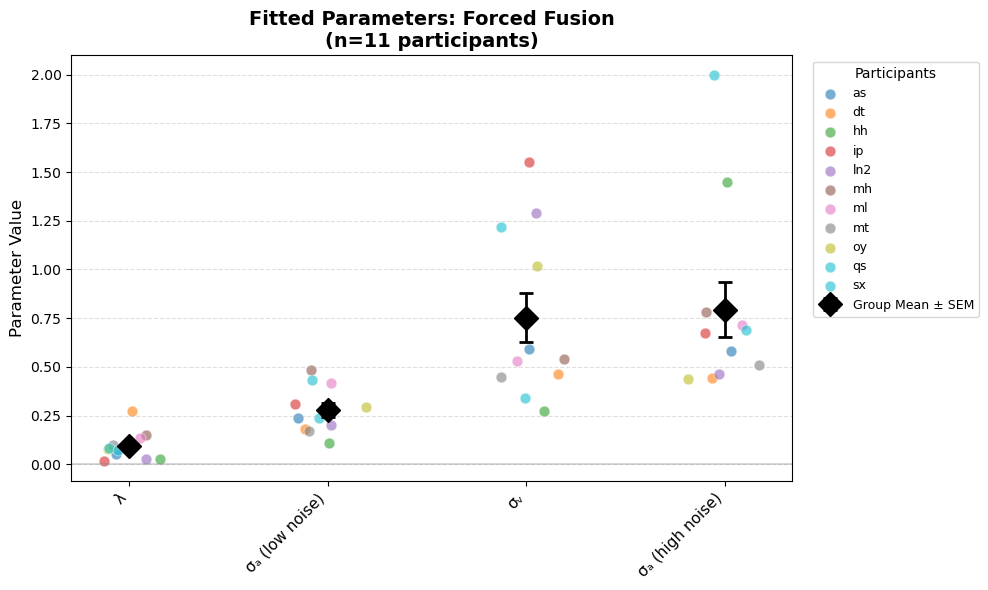


Model: Forced Fusion
Parameter                       Mean         SD        SEM        Min        Max
---------------------------------------------------------------------------
λ                             0.0930     0.0700     0.0211     0.0155     0.2739
σₐ (low noise)                0.2800     0.1154     0.0348     0.1080     0.4863
σᵥ                            0.7512     0.4170     0.1257     0.2754     1.5520
σₐ (high noise)               0.7947     0.4674     0.1409     0.4381     2.0000

Model 'Free Switching': 11 entries, 6 parameters
  Plotting 11 participants


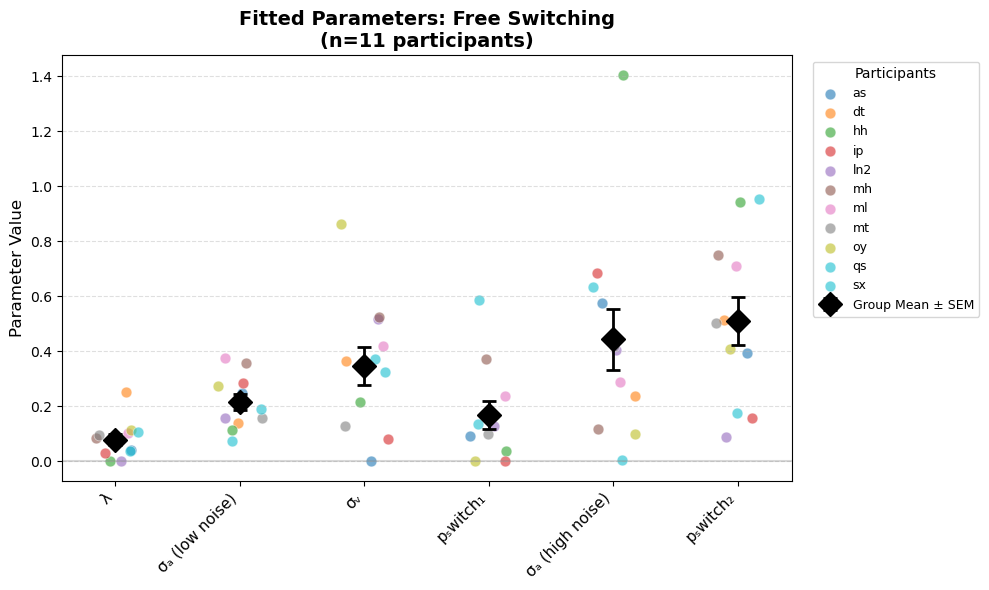


Model: Free Switching
Parameter                       Mean         SD        SEM        Min        Max
---------------------------------------------------------------------------
λ                             0.0786     0.0673     0.0203     0.0010     0.2510
σₐ (low noise)                0.2156     0.0952     0.0287     0.0727     0.3770
σᵥ                            0.3463     0.2313     0.0697     0.0001     0.8623
pₛwitch₁                      0.1685     0.1672     0.0504     0.0000     0.5873
σₐ (high noise)               0.4430     0.3723     0.1122     0.0054     1.4056
pₛwitch₂                      0.5087     0.2895     0.0873     0.0900     0.9547

Model 'Probbility-Matching CI': 11 entries, 5 parameters
  Plotting 11 participants


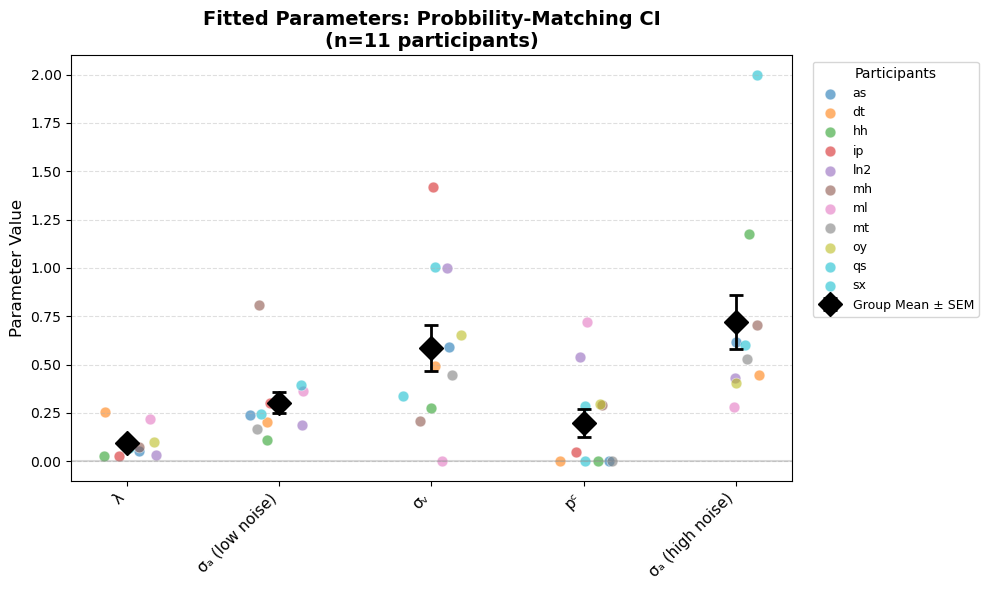


Model: Probbility-Matching CI
Parameter                       Mean         SD        SEM        Min        Max
---------------------------------------------------------------------------
λ                             0.0961     0.0720     0.0217     0.0255     0.2565
σₐ (low noise)                0.3024     0.1793     0.0541     0.1077     0.8087
σᵥ                            0.5842     0.3955     0.1193     0.0001     1.4200
pᶜ                            0.1983     0.2401     0.0724     0.0000     0.7207
σₐ (high noise)               0.7199     0.4623     0.1394     0.2812     1.9992

Model 'Selection CI': 11 entries, 5 parameters
  Plotting 11 participants


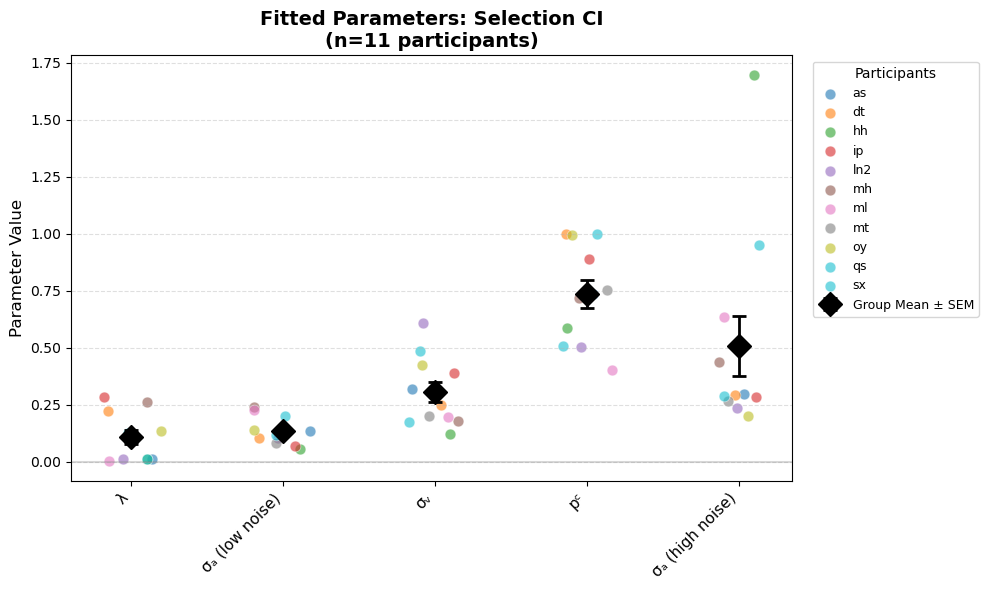


Model: Selection CI
Parameter                       Mean         SD        SEM        Min        Max
---------------------------------------------------------------------------
λ                             0.1069     0.1032     0.0311     0.0010     0.2814
σₐ (low noise)                0.1329     0.0591     0.0178     0.0566     0.2379
σᵥ                            0.3042     0.1475     0.0445     0.1216     0.6085
pᶜ                            0.7352     0.2077     0.0626     0.4010     1.0000
σₐ (high noise)               0.5070     0.4320     0.1303     0.2012     1.6980


In [95]:
# Plot Fitted Parameter Distributions for Each Model Separately
import numpy as np
import matplotlib.pyplot as plt

def get_param_names_for_model(model_name, n_params):
    """
    Get parameter names based on model name and actual parameter count.
    Adapts to both sharedLambda=True (5-6 params) and sharedLambda=False (7-8 params) configurations.
    """
    # Define base parameter templates
    if n_params == 5:
        # sharedLambda=True, causal inference: [λ, σa1, σv, pc, σa2]
        return ['λ', 'σₐ (low noise)', 'σᵥ', 'pᶜ', 'σₐ (high noise)']
    elif n_params == 4:
        # sharedLambda=True, fusion only: [λ, σa1, σv, σa2]
        return ['λ', 'σₐ (low noise)', 'σᵥ', 'σₐ (high noise)']
    elif n_params == 6:
        # Could be fusion with 3 lambdas OR switchingFree with sharedLambda
        if 'Fusion' in model_name or 'fusion' in model_name.lower():
            return ['λ₁', 'σₐ (low noise)', 'σᵥ', 'σₐ (high noise)', 'λ₂', 'λ₃']
        elif 'Free Switching' in model_name or 'switchingFree' in model_name.lower():
            return ['λ', 'σₐ (low noise)', 'σᵥ', 'pₛwitch₁', 'σₐ (high noise)', 'pₛwitch₂']
        else:
            # CI with freeP_c=True and sharedLambda=True: [λ, σa1, σv, pc1, σa2, pc2]
            return ['λ', 'σₐ (low noise)', 'σᵥ', 'pᶜ₁', 'σₐ (high noise)', 'pᶜ₂']
    elif n_params == 7:
        # sharedLambda=False, causal inference: [λ1, σa1, σv, pc, σa2, λ2, λ3]
        return ['λ₁', 'σₐ (low noise)', 'σᵥ', 'pᶜ', 'σₐ (high noise)', 'λ₂', 'λ₃']
    elif n_params == 8:
        # Could be switchingFree or switchingWithConflict with sharedLambda=False
        if 'Free Switching' in model_name or 'switchingFree' in model_name.lower():
            return ['λ₁', 'σₐ (low noise)', 'σᵥ', 'pₛwitch₁', 'σₐ (high noise)', 'λ₂', 'λ₃', 'pₛwitch₂']
        elif 'Conflict' in model_name:
            return ['λ₁', 'σₐ (low noise)', 'σᵥ', 'pᶜ', 'σₐ (high noise)', 'λ₂', 'λ₃', 'k']
        else:
            return ['λ₁', 'σₐ (low noise)', 'σᵥ', 'pᶜ₁', 'σₐ (high noise)', 'λ₂', 'λ₃', 'pᶜ₂']
    else:
        # Fallback: generic names
        return [f'Param {i+1}' for i in range(n_params)]


def plot_parameter_distributions_per_model(df_results, models_to_plot=None):
    """
    Plot fitted parameter distributions for each model separately.
    Shows individual participant points as scatter with jitter, 
    and group means with error bars.
    """
    if models_to_plot is None:
        models_to_plot = sorted(df_results['modelType'].unique())
    
    participantIDs = sorted([p for p in df_results['participantID'].unique() if p != 'all'])
    
    print(f"Found {len(models_to_plot)} models: {models_to_plot}")
    print(f"Found {len(participantIDs)} participants: {participantIDs}")
    
    # Create a figure for each model
    for model_name in models_to_plot:
        model_data = df_results[df_results['modelType'] == model_name]
        
        if len(model_data) == 0:
            print(f"No data for model: {model_name}")
            continue
        
        # Get actual number of parameters from first valid entry
        first_params = model_data['fittedParams'].iloc[0]
        n_params_actual = len(first_params)
        print(f"\nModel '{model_name}': {len(model_data)} entries, {n_params_actual} parameters")
        
        # Get parameter names based on actual param count and model name
        param_names = get_param_names_for_model(model_name, n_params_actual)
        
        # Collect parameter values for each participant
        param_values = {name: [] for name in param_names}
        valid_participants = []
        
        for pid in participantIDs:
            pid_data = model_data[model_data['participantID'] == pid]
            if len(pid_data) == 0:
                continue
            
            params = pid_data['fittedParams'].values[0]
            if len(params) != len(param_names):
                print(f"  Warning: {pid} has {len(params)} params, expected {len(param_names)}")
                continue
            
            valid_participants.append(pid)
            for i, name in enumerate(param_names):
                param_values[name].append(params[i])
        
        if len(valid_participants) == 0:
            print(f"  No valid participants for model: {model_name}")
            continue
        
        print(f"  Plotting {len(valid_participants)} participants")
        
        # Create the plot
        n_params = len(param_names)
        fig, ax = plt.subplots(figsize=(max(10, n_params * 1.5), 6))
        
        x_positions = np.arange(n_params)
        colors = plt.cm.tab10(np.linspace(0, 1, len(valid_participants)))
        
        # Plot individual participant points with jitter
        for i, pid in enumerate(valid_participants):
            y_values = [param_values[name][i] for name in param_names]
            jitter = np.random.uniform(-0.2, 0.2, size=n_params)
            ax.scatter(x_positions + jitter, y_values, 
                      color=colors[i], alpha=0.6, s=60, edgecolor='w', linewidth=0.5,
                      label=pid)
        
        # Calculate and plot group means with error bars (SEM)
        means = []
        sems = []
        for name in param_names:
            vals = np.array(param_values[name])
            means.append(np.mean(vals))
            sems.append(np.std(vals) / np.sqrt(len(vals)))
        
        ax.errorbar(x_positions, means, yerr=sems, 
                   fmt='D', color='black', markersize=12, 
                   capsize=5, capthick=2, elinewidth=2,
                   label='Group Mean ± SEM', zorder=10)
        
        # Formatting
        ax.set_xticks(x_positions)
        ax.set_xticklabels(param_names, rotation=45, ha='right', fontsize=11)
        ax.set_ylabel('Parameter Value', fontsize=12)
        ax.set_title(f'Fitted Parameters: {model_name}\n(n={len(valid_participants)} participants)', 
                    fontsize=14, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Add legend outside the plot
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, 
                 title='Participants', title_fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n{'='*60}")
        print(f"Model: {model_name}")
        print(f"{'='*60}")
        print(f"{'Parameter':<25} {'Mean':>10} {'SD':>10} {'SEM':>10} {'Min':>10} {'Max':>10}")
        print(f"{'-'*75}")
        for j, name in enumerate(param_names):
            vals = np.array(param_values[name])
            print(f"{name:<25} {np.mean(vals):>10.4f} {np.std(vals):>10.4f} {sems[j]:>10.4f} {np.min(vals):>10.4f} {np.max(vals):>10.4f}")

# Plot parameter distributions for all models
plot_parameter_distributions_per_model(df_results)

Extracted parameters from 55 model-participant combinations
Models: ['Averaging CI', 'Forced Fusion', 'Free Switching', 'Probbility-Matching CI', 'Selection CI']


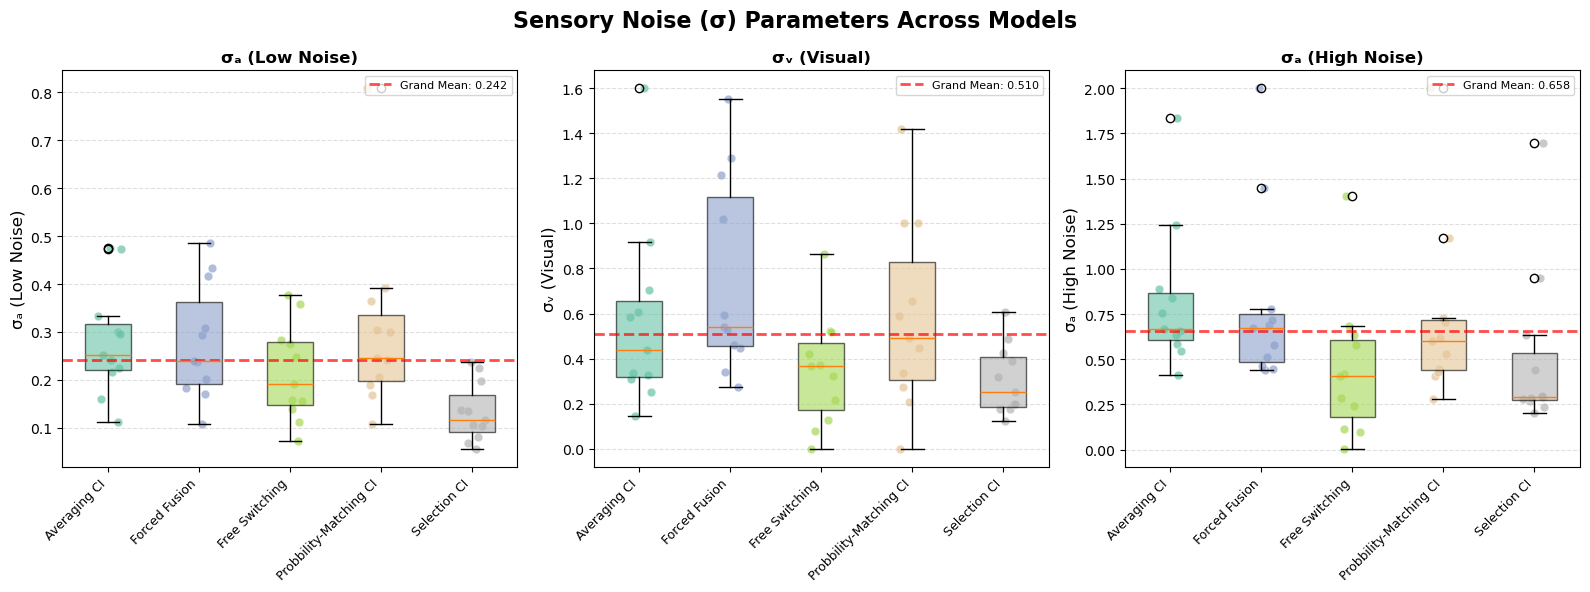

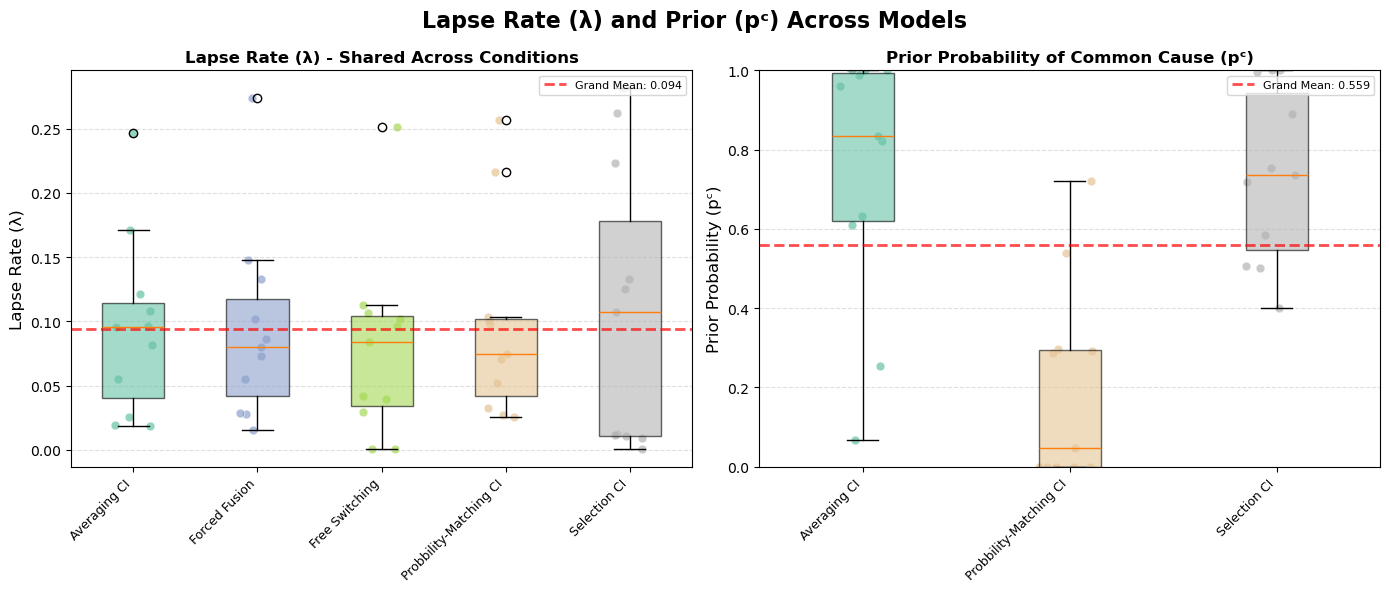

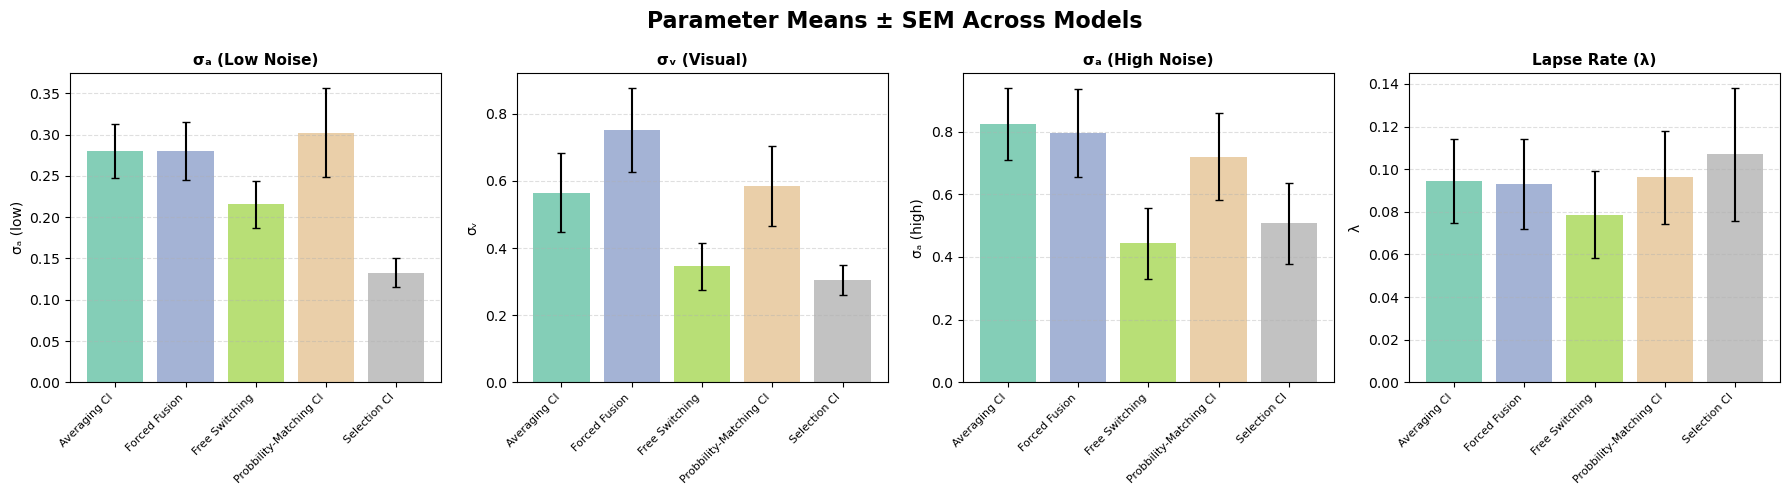


PARAMETER SUMMARY ACROSS MODELS (LapseFix - Shared λ)

Model                                     λ     σₐ (low)           σᵥ    σₐ (high)           pᶜ
----------------------------------------------------------------------------------------------------
Averaging CI                         0.0945       0.2803       0.5656       0.8238       0.7424
Forced Fusion                        0.0930       0.2800       0.7512       0.7947          N/A
Free Switching                       0.0786       0.2156       0.3463       0.4430          N/A
Probbility-Matching CI               0.0961       0.3024       0.5842       0.7199       0.1983
Selection CI                         0.1069       0.1329       0.3042       0.5070       0.7352
----------------------------------------------------------------------------------------------------
GRAND MEAN                           0.0938       0.2422       0.5103       0.6577       0.5586


In [97]:
# Plot Sigma and Lapse Rate Distributions Across All Models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def extract_common_params_across_models(df_results):
    """
    Extract sigma (sensory noise) and lapse rate parameters from all models.
    Returns a DataFrame with participant, model, and parameter values.
    
    For LapseFix models (sharedLambda=True), parameter structure is:
    - CI models (5 params): [λ, σₐ_low, σᵥ, pᶜ, σₐ_high]
    - Fusion models (4 params): [λ, σₐ_low, σᵥ, σₐ_high]
    - SwitchingFree (6 params): [λ, σₐ_low, σᵥ, p_switch1, σₐ_high, p_switch2]
    
    Only ONE shared lapse rate (λ) is used across all conditions.
    """
    records = []
    
    for _, row in df_results.iterrows():
        pid = row['participantID']
        model = row['modelType']
        params = row['fittedParams']
        n_params = len(params)
        
        if pid == 'all':
            continue
        
        # Extract based on parameter count (LapseFix = sharedLambda=True)
        if n_params == 5:
            # CI models: [λ, σₐ_low, σᵥ, pᶜ, σₐ_high]
            records.append({
                'participant': pid, 'model': model,
                'λ': params[0], 
                'σₐ (low)': params[1], 
                'σᵥ': params[2],
                'pᶜ': params[3],
                'σₐ (high)': params[4]
            })
        elif n_params == 4:
            # Fusion models: [λ, σₐ_low, σᵥ, σₐ_high]
            records.append({
                'participant': pid, 'model': model,
                'λ': params[0], 
                'σₐ (low)': params[1], 
                'σᵥ': params[2],
                'pᶜ': np.nan,  # No p_c for fusion models
                'σₐ (high)': params[3]
            })
        elif n_params == 6:
            # SwitchingFree: [λ, σₐ_low, σᵥ, p_switch1, σₐ_high, p_switch2]
            # Or freeP_c CI: [λ, σₐ_low, σᵥ, pᶜ₁, σₐ_high, pᶜ₂]
            if 'Free Switching' in model or 'switchingFree' in model.lower():
                records.append({
                    'participant': pid, 'model': model,
                    'λ': params[0], 
                    'σₐ (low)': params[1], 
                    'σᵥ': params[2],
                    'pᶜ': np.nan,  # p_switch, not p_c
                    'σₐ (high)': params[4]
                })
            else:
                records.append({
                    'participant': pid, 'model': model,
                    'λ': params[0], 
                    'σₐ (low)': params[1], 
                    'σᵥ': params[2],
                    'pᶜ': params[3],
                    'σₐ (high)': params[4]
                })
        elif n_params == 7:
            # sharedLambda=False CI: [λ₁, σₐ_low, σᵥ, pᶜ, σₐ_high, λ₂, λ₃]
            # Average the lapse rates for comparison
            records.append({
                'participant': pid, 'model': model,
                'λ': np.mean([params[0], params[5], params[6]]),  # Average of λ₁, λ₂, λ₃
                'σₐ (low)': params[1], 
                'σᵥ': params[2],
                'pᶜ': params[3],
                'σₐ (high)': params[4]
            })
        else:
            print(f"  Skipping {model} for {pid}: unexpected {n_params} parameters")
    
    return pd.DataFrame(records)


def plot_sigma_lapse_across_models(df_results):
    """
    Plot sigma (sensory noise) and lapse rate distributions across all models.
    For LapseFix models: one shared lapse rate (λ) + three sigmas + pᶜ.
    """
    # Extract common parameters
    params_df = extract_common_params_across_models(df_results)
    
    if len(params_df) == 0:
        print("No valid parameter data found!")
        return
    
    models = sorted(params_df['model'].unique())
    n_models = len(models)
    
    print(f"Extracted parameters from {len(params_df)} model-participant combinations")
    print(f"Models: {models}")
    
    # Color palette for models
    model_colors = plt.cm.Set2(np.linspace(0, 1, n_models))
    model_color_map = dict(zip(models, model_colors))
    
    # =========== FIGURE 1: Sigma (Sensory Noise) Parameters ===========
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle('Sensory Noise (σ) Parameters Across Models', fontsize=16, fontweight='bold')
    
    sigma_params = ['σₐ (low)', 'σᵥ', 'σₐ (high)']
    sigma_labels = ['σₐ (Low Noise)', 'σᵥ (Visual)', 'σₐ (High Noise)']
    
    for ax, param, label in zip(axes, sigma_params, sigma_labels):
        # Boxplot for each model
        data_by_model = [params_df[params_df['model'] == m][param].values for m in models]
        bp = ax.boxplot(data_by_model, patch_artist=True, positions=range(n_models))
        
        # Color the boxes
        for patch, model in zip(bp['boxes'], models):
            patch.set_facecolor(model_color_map[model])
            patch.set_alpha(0.6)
        
        # Overlay individual points with jitter
        for i, model in enumerate(models):
            model_data = params_df[params_df['model'] == model][param].values
            jitter = np.random.uniform(-0.15, 0.15, len(model_data))
            ax.scatter(i + jitter, model_data, 
                      color=model_color_map[model], alpha=0.7, s=40, edgecolor='w', linewidth=0.5)
        
        # Add grand mean line
        grand_mean = params_df[param].mean()
        ax.axhline(grand_mean, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Grand Mean: {grand_mean:.3f}')
        
        ax.set_xticks(range(n_models))
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel(label, fontsize=12)
        ax.set_title(label, fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # =========== FIGURE 2: Lapse Rate (λ) and Prior (pᶜ) ===========
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Lapse Rate (λ) and Prior (pᶜ) Across Models', fontsize=16, fontweight='bold')
    
    # Lapse rate (single λ)
    data_by_model = [params_df[params_df['model'] == m]['λ'].values for m in models]
    bp = ax1.boxplot(data_by_model, patch_artist=True, positions=range(n_models))
    
    for patch, model in zip(bp['boxes'], models):
        patch.set_facecolor(model_color_map[model])
        patch.set_alpha(0.6)
    
    for i, model in enumerate(models):
        model_data = params_df[params_df['model'] == model]['λ'].values
        jitter = np.random.uniform(-0.15, 0.15, len(model_data))
        ax1.scatter(i + jitter, model_data, 
                   color=model_color_map[model], alpha=0.7, s=40, edgecolor='w', linewidth=0.5)
    
    grand_mean_lambda = params_df['λ'].mean()
    ax1.axhline(grand_mean_lambda, color='red', linestyle='--', linewidth=2, alpha=0.7, 
               label=f'Grand Mean: {grand_mean_lambda:.3f}')
    
    ax1.set_xticks(range(n_models))
    ax1.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax1.set_ylabel('Lapse Rate (λ)', fontsize=12)
    ax1.set_title('Lapse Rate (λ) - Shared Across Conditions', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', linestyle='--', alpha=0.4)
    ax1.legend(loc='upper right', fontsize=8)
    
    # Prior probability (pᶜ) - exclude NaN values (fusion models don't have pᶜ)
    params_with_pc = params_df.dropna(subset=['pᶜ'])
    models_with_pc = [m for m in models if m in params_with_pc['model'].unique()]
    n_models_pc = len(models_with_pc)
    
    if n_models_pc > 0:
        data_by_model_pc = [params_with_pc[params_with_pc['model'] == m]['pᶜ'].values for m in models_with_pc]
        bp2 = ax2.boxplot(data_by_model_pc, patch_artist=True, positions=range(n_models_pc))
        
        for patch, model in zip(bp2['boxes'], models_with_pc):
            patch.set_facecolor(model_color_map[model])
            patch.set_alpha(0.6)
        
        for i, model in enumerate(models_with_pc):
            model_data = params_with_pc[params_with_pc['model'] == model]['pᶜ'].values
            jitter = np.random.uniform(-0.15, 0.15, len(model_data))
            ax2.scatter(i + jitter, model_data, 
                       color=model_color_map[model], alpha=0.7, s=40, edgecolor='w', linewidth=0.5)
        
        grand_mean_pc = params_with_pc['pᶜ'].mean()
        ax2.axhline(grand_mean_pc, color='red', linestyle='--', linewidth=2, alpha=0.7, 
                   label=f'Grand Mean: {grand_mean_pc:.3f}')
        
        ax2.set_xticks(range(n_models_pc))
        ax2.set_xticklabels(models_with_pc, rotation=45, ha='right', fontsize=9)
        ax2.set_ylabel('Prior Probability (pᶜ)', fontsize=12)
        ax2.set_title('Prior Probability of Common Cause (pᶜ)', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1)
        ax2.grid(axis='y', linestyle='--', alpha=0.4)
        ax2.legend(loc='upper right', fontsize=8)
    else:
        ax2.text(0.5, 0.5, 'No models with pᶜ parameter', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Prior Probability (pᶜ)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # =========== FIGURE 3: Summary Bar Plot (Means ± SEM) ===========
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle('Parameter Means ± SEM Across Models', fontsize=16, fontweight='bold')
    
    all_params = ['σₐ (low)', 'σᵥ', 'σₐ (high)', 'λ']
    all_labels = ['σₐ (Low Noise)', 'σᵥ (Visual)', 'σₐ (High Noise)', 'Lapse Rate (λ)']
    
    for ax, param, label in zip(axes, all_params, all_labels):
        means = []
        sems = []
        for model in models:
            vals = params_df[params_df['model'] == model][param].dropna().values
            if len(vals) > 0:
                means.append(np.mean(vals))
                sems.append(np.std(vals) / np.sqrt(len(vals)))
            else:
                means.append(0)
                sems.append(0)
        
        bars = ax.bar(range(n_models), means, yerr=sems, capsize=3, alpha=0.8, 
                     color=[model_color_map[m] for m in models])
        ax.set_xticks(range(n_models))
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
        ax.set_ylabel(param, fontsize=10)
        ax.set_title(label, fontsize=11, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()
    
    # =========== Print Summary Statistics ===========
    print("\n" + "="*100)
    print("PARAMETER SUMMARY ACROSS MODELS (LapseFix - Shared λ)")
    print("="*100)
    
    all_params_print = ['λ', 'σₐ (low)', 'σᵥ', 'σₐ (high)', 'pᶜ']
    
    print(f"\n{'Model':<30} " + " ".join([f"{p:>12}" for p in all_params_print]))
    print("-"*100)
    
    for model in models:
        model_data = params_df[params_df['model'] == model]
        means = []
        for p in all_params_print:
            vals = model_data[p].dropna()
            if len(vals) > 0:
                means.append(f"{vals.mean():.4f}")
            else:
                means.append("    N/A")
        print(f"{model:<30} " + " ".join([f"{m:>12}" for m in means]))
    
    print("-"*100)
    overall_means = []
    for p in all_params_print:
        vals = params_df[p].dropna()
        if len(vals) > 0:
            overall_means.append(f"{vals.mean():.4f}")
        else:
            overall_means.append("    N/A")
    print(f"{'GRAND MEAN':<30} " + " ".join([f"{m:>12}" for m in overall_means]))
    
    return params_df


# Run the cross-model parameter analysis
params_comparison_df = plot_sigma_lapse_across_models(df_results)

In [ ]:
# Plot Delta Log Likelihood Comparison Table
import matplotlib.pyplot as plt
import seaborn as sns

def plot_delta_log_likelihood_comparison_table(df_results):
    """Create a comprehensive delta log likelihood comparison plot"""
    
    # Sort participants by sum of delta_LL (lower is better since it's distance from best)
    participant_delta_ll_sums = df_results.groupby('participantID')['delta_LL'].sum().sort_values()
    sorted_participants = participant_delta_ll_sums.index.tolist()
    
    # Create the pivot table with sorted participants for delta log likelihoods
    df_delta_ll = df_results.pivot(index='participantID', columns='modelType', values='delta_LL')
    df_delta_ll = df_delta_ll.reindex(sorted_participants)
    
    # Find best model for each participant (lowest delta_LL = highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['delta_LL'].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by ΔLog Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta log likelihood values
    sns.heatmap(df_delta_ll, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': 'ΔLog Likelihood (lower = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Delta Log Likelihood by Participant (Sorted by Sum of ΔLL)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by sum of ΔLL)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (black borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_ll.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Sum Delta LL per model
    sum_delta_ll = df_delta_ll.sum(axis=0).sort_values()
    colors = plt.cm.Set3(range(len(sum_delta_ll)))
    
    bars = ax2.barh(range(len(sum_delta_ll)), sum_delta_ll.values, color=colors)
    ax2.set_yticks(range(len(sum_delta_ll)))
    ax2.set_yticklabels(sum_delta_ll.index, fontsize=10)
    ax2.set_xlabel('Sum ΔLog Likelihood', fontsize=12)
    ax2.set_title('Sum ΔLog Likelihood\nper Model', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sum_delta_ll.values)):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Line plot showing sum of delta LL per model
    plt.figure(figsize=(10, 6))
    plt.plot(sum_delta_ll.index, sum_delta_ll.values, marker='o', linestyle='-', color='purple')
    plt.title('Sum of ΔLog Likelihood Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel('Sum of ΔLog Likelihood', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    # Add value labels on points
    for i, value in enumerate(sum_delta_ll.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by sum of ΔLog Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Sum ΔLL':<10} {'Best Model':<18} {'Min ΔLL':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_ll = participant_data['delta_LL'].sum()
        min_delta_ll = participant_data['delta_LL'].min()
        best_model = participant_data.loc[participant_data['delta_LL'].idxmin(), 'modelType']
        
        if sum_delta_ll <= 5:
            performance = "Excellent fit"
        elif sum_delta_ll <= 15:
            performance = "Good fit"
        elif sum_delta_ll <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_ll:<10.1f} {best_model:<18} {min_delta_ll:<10.1f} {performance:<15}")
    
    return df_delta_ll, best_models, participant_delta_ll_sums

# Create the delta log likelihood visualization
delta_ll_table, delta_ll_best_models, delta_ll_sums = plot_delta_log_likelihood_comparison_table(df_results)

KeyError: 'Column not found: delta_LL'

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Create detailed parameter description table
def create_parameter_description_table():
    """Generate a LaTeX table describing parameters for each model"""
    
    latex = r"""\begin{table}[htbp]
\centering
\caption{Model Parameter Descriptions}
\label{tab:model_parameters}
\begin{threeparttable}
\begin{tabular}{l c c c c c}
\toprule
\textbf{Model} & \textbf{Lapse} & \textbf{Sensory} & \textbf{Prior} & \textbf{Other} & \textbf{Total} \\
 & \textbf{Rates} & \textbf{Noise} & \textbf{$p_c$} & \textbf{Params} & \textbf{$n$} \\
\midrule
Free Switching & 3 & 3 & \checkmark & $w$ & 8 \\
Forced Fusion & 3 & 3 & -- & -- & 6 \\
Prob-Matching CI & 3 & 3 & \checkmark & -- & 7 \\
Averaging CI & 3 & 3 & \checkmark & -- & 7 \\
Log-Linear Mismatch & 3 & 3 & \checkmark & -- & 7 \\
Selection CI & 3 & 3 & \checkmark & -- & 7 \\
\bottomrule
\end{tabular}
\begin{tablenotes}[flushleft]
\small
\item \textit{Lapse Rates:} $\lambda_1, \lambda_2, \lambda_3$ for low-noise auditory, high-noise auditory, and cross-modal conditions.
\item \textit{Sensory Noise:} $\sigma_a, \sigma_v, \sigma_{a2}$ representing auditory (low-noise), visual, and auditory (high-noise) standard deviations in log-space.
\item \textit{Prior:} $p_c$ is the prior probability of a common cause.
\item \textit{Other:} $w$ is the switching weight parameter (Free Switching model only).
\end{tablenotes}
\end{threeparttable}
\end{table}"""
    
    return latex

latex_param_table = create_parameter_description_table()

print("LaTeX Parameter Description Table:")
print("=" * 80)
print(latex_param_table)
print("\n" + "=" * 80)

LaTeX Parameter Description Table:
\begin{table}[htbp]
\centering
\caption{Model Parameter Descriptions}
\label{tab:model_parameters}
\begin{threeparttable}
\begin{tabular}{l c c c c c}
\toprule
\textbf{Model} & \textbf{Lapse} & \textbf{Sensory} & \textbf{Prior} & \textbf{Other} & \textbf{Total} \\
 & \textbf{Rates} & \textbf{Noise} & \textbf{$p_c$} & \textbf{Params} & \textbf{$n$} \\
\midrule
Free Switching & 3 & 3 & \checkmark & $w$ & 8 \\
Forced Fusion & 3 & 3 & -- & -- & 6 \\
Prob-Matching CI & 3 & 3 & \checkmark & -- & 7 \\
Averaging CI & 3 & 3 & \checkmark & -- & 7 \\
Log-Linear Mismatch & 3 & 3 & \checkmark & -- & 7 \\
Selection CI & 3 & 3 & \checkmark & -- & 7 \\
\bottomrule
\end{tabular}
\begin{tablenotes}[flushleft]
\small
\item \textit{Lapse Rates:} $\lambda_1, \lambda_2, \lambda_3$ for low-noise auditory, high-noise auditory, and cross-modal conditions.
\item \textit{Sensory Noise:} $\sigma_a, \sigma_v, \sigma_{a2}$ representing auditory (low-noise), visual, and auditory (h

: 

: 

: 